[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

これで、いくつかのことを深く理解することができました： 

* グラフの状態スキーマをカスタマイズする方法
* カスタムstate reducerの定義方法
* 複数のグラフstate schema の使用方法

## Goals

さて、これらのコンセプトをLangGraphのモデルで使い始めましょう！

次の数セッションでは、長期記憶(long-term memory)を持つチャットボットを作ります。

私たちのチャットボットはメッセージを使うので、まずはグラフステートでメッセージを扱う高度な方法についてもう少しお話ししましょう。


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os
import getpass


def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

[tracing](https://docs.smith.langchain.com/concepts/tracing)には[LangSmith](https://docs.smith.langchain.com/)を使います。

`langchain-academy`というプロジェクトにログを記録します。


In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state

まず、メッセージを定義します。

In [3]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [
    AIMessage(
        "海の哺乳類を研究していると言いましたね？",
        name="Bot",
    )
]
messages.append(
    HumanMessage(
        "はい、クジラについては知っています。でも、他にどんなことを学べばいいですか？",
        name="Lance",
    )
)

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

海の哺乳類を研究していると言いましたね？
================================ Human Message =================================
Name: Lance

はい、クジラについては知っています。でも、他にどんなことを学べばいいですか？


メッセージをチャットモデルに渡すことができます。

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-2024-08-06")
llm.invoke(messages)

AIMessage(content='海の哺乳類について学ぶ際には、クジラの他にも様々な側面があります。以下はいくつかの考慮すべきトピックです：\n\n1. **生態と行動**: イルカ、アシカ、アザラシ、マナティーなど、他の海の哺乳類の生態や行動について学ぶことは重要です。彼らの社会構造、移動パターン、繁殖行動などに注目してみてください。\n\n2. **進化と分類**: 海の哺乳類がどのように進化して現在の形になったのか、またどのように分類されているのかを理解することは非常に興味深いです。\n\n3. **生理学**: 海の哺乳類が水中環境に適応するためにどのような生理学的特性を持っているのかを学ぶと、彼らの驚くべき適応能力を理解することができます。\n\n4. **保全と環境問題**: 海洋哺乳類は環境汚染や気候変動、漁業活動などの影響を受けています。これらの生物を保護するための努力や課題について学ぶことは重要です。\n\n5. **文化的および歴史的な側面**: 人間と海の哺乳類との関係は長い歴史があり、文化的な影響も大きいです。これには神話や伝説、芸術、そして現代における観光や保護活動も含まれます。\n\nこれらのトピックに興味を持ち、さらに深く掘り下げることで、海の哺乳類についての理解を深めることができるでしょう。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 423, 'prompt_tokens': 53, 'total_tokens': 476, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_2f406b9113', 'finish_reason': 'stop', 'logprobs': None}, id='run-e4fcb099-707e-43f4-b12c-e07c6483f2ec-0', usage_metadata={'input_tokens': 53, 'output_tokens': 423, 'tota

`MessagesState`を使えば、単純なグラフの中でチャットモデルを動かすことができます。

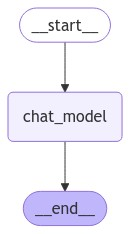

In [5]:
from IPython.display import Image, display
from langchain_core.messages.base import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END


# Node
def chat_model_node(state: MessagesState) -> dict[str, BaseMessage]:
    return {"messages": llm.invoke(state["messages"])}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

海の哺乳類を研究していると言いましたね？
================================ Human Message =================================
Name: Lance

はい、クジラについては知っています。でも、他にどんなことを学べばいいですか？
================================== Ai Message ==================================

クジラについて既に知識があるのでしたら、次のステップとして以下のトピックを学ぶことをお勧めします：

1. **イルカとシャチ**: クジラと同じく鯨偶蹄目に属する哺乳類ですが、行動や社会構造が異なります。特にシャチは複雑な社会構造を持ち、地域によって異なる文化を持っていることが知られています。

2. **セイウチとアザラシ**: これらは海の哺乳類の中で、海岸や氷上での生活に適応した種です。彼らの生態、繁殖行動、食性について学ぶと、海洋生態系全体の理解が深まります。

3. **海牛（ジュゴンとマナティ）**: 温暖な沿岸海域に生息する草食性の海洋哺乳類で、彼らの生態や保護状況について学ぶことは、海洋保護の重要性を理解するのに役立ちます。

4. **海洋哺乳類の保護と保存**: 海洋哺乳類は多くの脅威にさらされています。気候変動、海洋汚染、漁業との競争などの問題について学び、それらを保護するための国際的な取り組みや法律について知識を深めることが重要です。

5. **音響生態学**: 多くの海洋哺乳類は音を使ってコミュニケーションを取ったり、餌を探したりします。音響生態学を学ぶことで、彼らの行動や社会構造をより深く理解することができます。

これらのトピックを学ぶことで、海洋哺乳類全般に関する知識を広げることができると思います。興味のある分野から始めて、徐々に理解を深めていくと良いでしょう。


## Reducer

メッセージを扱う際の現実的な課題は、長く続く(long-running)会話を管理することです。

長く続く会話は、気をつけないとトークンの使用量が多くなり、待ち時間が長くなります、というのも、どんどん増えていくメッセージのリストをモデルに渡すからです。

これに対処する方法はいくつかあります。

まず、 `RemoveMessage` と `add_messages` reducerを使ったトリックを思い出してください。


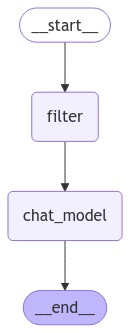

In [7]:
from langchain_core.messages import RemoveMessage
from langchain_core.messages.base import BaseMessage


# Nodes
def filter_messages(state: MessagesState) -> dict[str, list[RemoveMessage]]:
    # Delete all but the 2 most recent messages
    # 最新の2つのメッセージ以外を削除
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}


def chat_model_node(state: MessagesState) -> dict[str, list[BaseMessage]]:
    return {"messages": [llm.invoke(state["messages"])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# 前置き付きの message list。前置き = こんにちは。こんにちは。 です。
messages = [AIMessage("こんにちは。", name="Bot", id="1")]
messages.append(HumanMessage("こんにちは。", name="Lance", id="2"))
messages.append(
    AIMessage(
        "海洋哺乳類の研究をしているとおっしゃっていましたよね？",
        name="Bot",
        id="3",
    )
)
messages.append(
    HumanMessage(
        "ええ、クジラについては知っています。でも、他にどんなことを学べばいいですか？",
        name="Lance",
        id="4",
    )
)

# Invoke
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

海洋哺乳類の研究をしているとおっしゃっていましたよね？
================================ Human Message =================================
Name: Lance

ええ、クジラについては知っています。でも、他にどんなことを学べばいいですか？
================================== Ai Message ==================================

海洋哺乳類、特にクジラについての研究を深めるには、以下のいくつかの分野について学ぶと良いでしょう：

1. **生物学と解剖学**: クジラの体の構造と機能についての詳細な理解が必要です。骨格、筋肉、内臓の配置、呼吸システムなどを学びましょう。

2. **生態学**: クジラがどのように生態系の中で役割を果たしているかを理解することは重要です。食物連鎖における位置、捕食者-被食者関係、繁殖行動、生息地の選択などを調査します。

3. **行動学**: クジラの社会構造、コミュニケーション方法、移動パターンなどを研究することで、彼らの生活様式を理解することができます。

4. **保全生物学**: クジラは多くの種が絶滅危惧種に指定されています。そのため、保全戦略や政策、環境保護活動について学ぶことが重要です。

5. **音響学**: クジラは非常に複雑な音を使ってコミュニケーションを行います。音波の研究を通じて、彼らのコミュニケーション方法や音を使ったナビゲーションの理解を深めましょう。

6. **気候変動の影響**: 気候変動が海洋環境に与える影響について学び、それがクジラの生態や分布にどのように影響するかを理解します。

7. **遺伝学**: クジラの遺伝的多様性や進化の過程を研究することで、種の適応や進化の歴史を理解することが可能です。

これらの分野を学ぶことで、クジラについての理解がより深まるでしょう。具体的な研究や調査に参加することも、知識を実践的に応用する良い機会です。


## Filtering messages

グラフの状態を変更する必要がない場合、または変更したくない場合は、チャットモデルに渡すメッセージをフィルタリングすることができます。

例えば、フィルタリングされたリストを渡すだけです: `llm.invoke(messages[-1:])`をモデルに渡します。

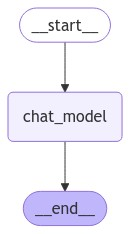

In [9]:
from langchain_core.messages.base import BaseMessage


# Node
def chat_model_node(state: MessagesState) -> dict[str, list[BaseMessage]]:
    return {"messages": [llm.invoke(state["messages"][-1:])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

既存のメッセージのリストを受け取り、上記のLLMの応答を追加し、フォローアップの質問を追加してみましょう。

In [10]:
messages.append(output["messages"][-1])
messages.append(HumanMessage("イッカクというクジラについて教えて下さい!", name="Lance"))

In [11]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

こんにちは。
================================ Human Message =================================
Name: Lance

こんにちは。
================================== Ai Message ==================================
Name: Bot

海洋哺乳類の研究をしているとおっしゃっていましたよね？
================================ Human Message =================================
Name: Lance

ええ、クジラについては知っています。でも、他にどんなことを学べばいいですか？
================================== Ai Message ==================================

海洋哺乳類、特にクジラについての研究を深めるには、以下のいくつかの分野について学ぶと良いでしょう：

1. **生物学と解剖学**: クジラの体の構造と機能についての詳細な理解が必要です。骨格、筋肉、内臓の配置、呼吸システムなどを学びましょう。

2. **生態学**: クジラがどのように生態系の中で役割を果たしているかを理解することは重要です。食物連鎖における位置、捕食者-被食者関係、繁殖行動、生息地の選択などを調査します。

3. **行動学**: クジラの社会構造、コミュニケーション方法、移動パターンなどを研究することで、彼らの生活様式を理解することができます。

4. **保全生物学**: クジラは多くの種が絶滅危惧種に指定されています。そのため、保全戦略や政策、環境保護活動について学ぶことが重要です。

5. **音響学**: クジラは非常に複雑な音を使ってコミュニケーションを行います。音波の研究を通じて、彼らのコミュニケーション方法や音を使ったナビゲーションの理解を深めましょう。

6. **気候変動の影

In [12]:
# メッセージフィルタリングを使って起動
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

こんにちは。
================================ Human Message =================================
Name: Lance

こんにちは。
================================== Ai Message ==================================
Name: Bot

海洋哺乳類の研究をしているとおっしゃっていましたよね？
================================ Human Message =================================
Name: Lance

ええ、クジラについては知っています。でも、他にどんなことを学べばいいですか？
================================== Ai Message ==================================

海洋哺乳類、特にクジラについての研究を深めるには、以下のいくつかの分野について学ぶと良いでしょう：

1. **生物学と解剖学**: クジラの体の構造と機能についての詳細な理解が必要です。骨格、筋肉、内臓の配置、呼吸システムなどを学びましょう。

2. **生態学**: クジラがどのように生態系の中で役割を果たしているかを理解することは重要です。食物連鎖における位置、捕食者-被食者関係、繁殖行動、生息地の選択などを調査します。

3. **行動学**: クジラの社会構造、コミュニケーション方法、移動パターンなどを研究することで、彼らの生活様式を理解することができます。

4. **保全生物学**: クジラは多くの種が絶滅危惧種に指定されています。そのため、保全戦略や政策、環境保護活動について学ぶことが重要です。

5. **音響学**: クジラは非常に複雑な音を使ってコミュニケーションを行います。音波の研究を通じて、彼らのコミュニケーション方法や音を使ったナビゲーションの理解を深めましょう。

6. **気候変動の影

ステートにはすべてのメッセージがあります。

しかし、LangSmithのトレースを見て、モデル呼び出しが最後のメッセージしか使っていないことを確認しましょう:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r 
(注意:これは原文の英文でChatしたときのリンクです)

## Trim messages

もう一つの方法は、[trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens)で、トークンの数 を指定する方法です。

これはメッセージの履歴を指定されたトークン数に制限します。

フィルタリングはエージェント間のメッセージのポストホックサブセット(post-hoc subset)を返すだけですが、trimmingはチャットモデルが応答するために使用できるトークンの数を制限します。

以下の `trim_messages` を参照してください。


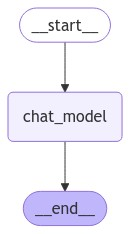

In [13]:
from langchain_core.messages import trim_messages
from langchain_core.messages.base import BaseMessage


# Node
def chat_model_node(state: MessagesState) -> dict[str, list[BaseMessage]]:
    messages = trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",
        token_counter=ChatOpenAI(model="gpt-4o-2024-08-06"),
        allow_partial=False,
    )
    return {"messages": [llm.invoke(messages)]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output["messages"][-1])
messages.append(HumanMessage("シャチの居場所を教えて!", name="Lance"))

In [16]:
# Example of trimming messages
trim_messages(
    messages,
    max_tokens=100,
    strategy="last",
    token_counter=ChatOpenAI(model="gpt-4o-2024-08-06"),
    allow_partial=False,
)

[HumanMessage(content='シャチの居場所を教えて!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [17]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({"messages": messages})

LangSmithのトレースでモデルの呼び出しを見てみましょう：

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r (注意:これは原文の英文でChatしたときのリンクです)